## **Training Faster R-CNN Object Detection on a Custom Dataset**

### **Overview**

This notebook walks through how to train a Faster R-CNN object detection model using the Detectron2 API.

In this specific example, we'll training an object detection model to recognize Nodes (Oatmeal nodes). **To adapt this example to train on different dataset: links, you only need to change two lines of code in this notebook.**

**Node Detection Example**

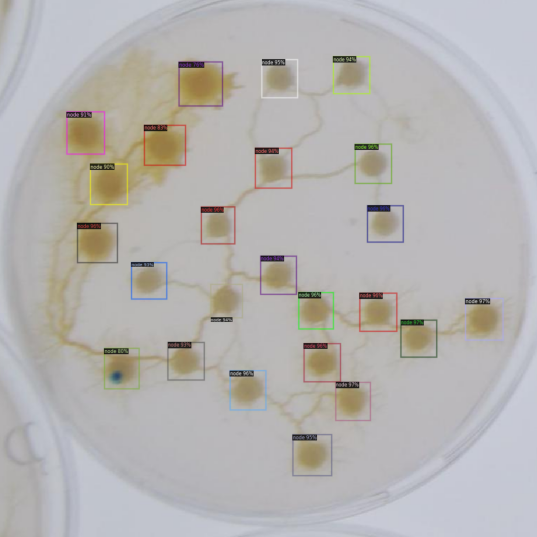

### **Our Data**

We'll be using a Physarum networks dataset issued from biological dataset in collaboration with CNRS. Our dataset contains 192 images (and annotations!)

### **Our Model**

We'll be training a MASK R_CNN neural network, an extension of Faster R-CNN neural network. Faster R-CNN is a two-stage detector: first it identifies regions of interest, and then passes these regions to a convolutional neural network. The outputted features maps are passed to a support vector machine (SVM) for classification. Regression between predicted bounding boxes and ground truth bounding boxes are computed. (Consider [this](https://towardsdatascience.com/faster-r-cnn-object-detection-implemented-by-keras-for-custom-data-from-googles-open-images-125f62b9141a) deep dive for more!)

The model arechitecture is one of many available via Detectron's [model zoo](https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md).


## **Mount Drive**

### **Overview**

The datasset is expected to be uploaded in google drive. Make sure you have the space for this dataset or a new one

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing Libraries for ML**

In [ ]:
!pip install torch torchvision -f https://download.pytorch.org/whl/torch_stable.html
!pip install git+https://github.com/facebookresearch/fvcore.git
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-fo191tml
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-fo191tml
  Resolved https://github.com/facebookresearch/fvcore.git to commit b905b9bfcaba54e04fd63054315f8120d0295975
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.6-py3-none-any.whl size=65266 sha256=25c898793529bceac214202a5c32664e0e0652d3cc8f7d96d83d96d943b1f3cf
  Stored in directory: /tmp/pip-ephem-wheel-cache-s5uwfwvu/wheels/8f/cb/6a/3b7ac0e01781855ca3d1417ebf9e15e20d5b7fe37ab063aa50
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31531 sha256=06fcff9c2a7eeb98c2de77a97af85e2b4a5033dca09a3401941910b0f36e1789
  Stored in dir

**Note**

Restarting the notebook is necessary to install detectron2. A button will appear to restart.
After restarting, continue executing cells one by one

**Installing Libraries for dataset**

In [ ]:
# !pip install -q pycocotools
from pycocotools.coco import COCO

**Defining the path to Root Data**

In [ ]:
data_dir = "/content/drive/My Drive/physarum"
import os
SEP = os.path.sep

**Defining the path for: images location, traning+testing annotations**

In [ ]:
img_dir = os.path.join(data_dir, "images")
annotations_file_train = data_dir + SEP + "annotation_v3"+ SEP +"train.json"
annotations_file_test = data_dir + SEP + "annotation_v3"+ SEP +"val.json"


**Importing additional Ml& image processing libraries**

In [ ]:
from detectron2.data import MetadataCatalog
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

from matplotlib.offsetbox import bbox_artist
import math
import networkx as nx

**Transforming the dataset annotation in coco object**

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("physarum_train", {}, annotations_file_train, img_dir)
register_coco_instances("physarum_test", {}, annotations_file_test, img_dir)

**Loading the dataset images in coco object**

In [ ]:
physarum_metadata = MetadataCatalog.get("physarum_train")
dataset_dicts = DatasetCatalog.get("physarum_train")

[07/21 07:25:52 d2.data.datasets.coco]: Loading /content/drive/My Drive/LABSOFT/physarum/annotation_v3/train.json takes 1.19 seconds.
[07/21 07:25:52 d2.data.datasets.coco]: Loaded 192 images in COCO format from /content/drive/My Drive/LABSOFT/physarum/annotation_v3/train.json


**Visualizing an image from dataset**

In [ ]:
import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=physarum_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## **Training**

**Defining the path of the model to be saved**

In [ ]:
path_model_torch = os.path.join(data_dir, "torch_models_complet")

In [ ]:
import os
#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()

# cfg.merge_from_file("./detectron2_repo/configs/COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.MASK_ON = True
cfg.DATASETS.TRAIN = ("physarum_train",) # physarum_train is the name of the folder that contains train images
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://ImageNetPretrained/MSRA/R-50.pkl"  # initialize from model zoo
# cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849458/model_final_f10217.pkl"
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.OUTPUT_DIR = path_model_torch
cfg.SOLVER.BASE_LR = 0.00075    #0.00025
cfg.SOLVER.MAX_ITER = 3000    # 600 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 8   # 8, faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # corresponds to the number of classes (object) to be detected
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.45

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[07/21 07:25:54 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

R-50.pkl: 102MB [00:00, 133MB/s]                            

[07/21 07:25:55 d2.checkpoint.c2_model_loading]: Renaming Caffe2 weights ......


[07/21 07:25:56 d2.checkpoint.c2_model_loading]: Following weights matched with submodule backbone.bottom_up:
| Names in Model    | Names in Checkpoint      | Shapes                                          |
|:------------------|:-------------------------|:------------------------------------------------|
| res2.0.conv1.*    | res2_0_branch2a_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| res2.0.conv2.*    | res2_0_branch2b_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.0.conv3.*    | res2_0_branch2c_{bn_*,w} | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.0.shortcut.* | res2_0_branch1_{bn_*,w}  | (256,) (256,) (256,) (256,) (256,64,1,1)        |
| res2.1.conv1.*    | res2_1_branch2a_{bn_*,w} | (64,) (64,) (64,) (64,) (64,256,1,1)            |
| res2.1.conv2.*    | res2_1_branch2b_{bn_*,w} | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| res2.1.conv3.*    | res2_1_branch2c_{bn_*,w} | (256,) (256,) (256,) (256,) (256,64,1,1)        |

backbone.fpn_lateral2.{bias, weight}
backbone.fpn_lateral3.{bias, weight}
backbone.fpn_lateral4.{bias, weight}
backbone.fpn_lateral5.{bias, weight}
backbone.fpn_output2.{bias, weight}
backbone.fpn_output3.{bias, weight}
backbone.fpn_output4.{bias, weight}
backbone.fpn_output5.{bias, weight}
proposal_generator.rpn_head.anchor_deltas.{bias, weight}
proposal_generator.rpn_head.conv.{bias, weight}
proposal_generator.rpn_head.objectness_logits.{bias, weight}
roi_heads.box_head.fc1.{bias, weight}
roi_heads.box_head.fc2.{bias, weight}
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.deconv.{bias, weight}
roi_heads.mask_head.mask_fcn1.{bias, weight}
roi_heads.mask_head.mask_fcn2.{bias, weight}
roi_heads.mask_head.mask_fcn3.{bias, weight}
roi_heads.mask_head.mask_fcn4.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}
  fc1000.{bias, weight}
  stem.conv1.bias


# **Testing on Test DataSet**

In [ ]:
model_save_name = "model_final.pth"
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, model_save_name)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("physarum_test", )
predictor = DefaultPredictor(cfg)

[07/21 07:25:59 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/My Drive/LABSOFT/physarum/torch_models_complet/model_final.pth ...


## **Evaluation**

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("physarum_test", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "physarum_test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[07/21 07:26:06 d2.data.datasets.coco]: Loaded 65 images in COCO format from /content/drive/My Drive/LABSOFT/physarum/annotation_v3/val.json
[07/21 07:26:06 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|     Np     | 769          |     Lp     | 1263         |     Ns     | 274          |
|            |              |            |              |            |              |
|   total    | 2306         |            |              |            |              |
[07/21 07:26:06 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/21 07:26:06 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[07/21 07:26:06 d2.data.common]: Serializing 65 el

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[07/21 07:26:12 d2.evaluation.evaluator]: Inference done 11/65. Dataloading: 0.0067 s/iter. Inference: 0.0936 s/iter. Eval: 0.0929 s/iter. Total: 0.1932 s/iter. ETA=0:00:10
[07/21 07:26:17 d2.evaluation.evaluator]: Inference done 38/65. Dataloading: 0.0085 s/iter. Inference: 0.0917 s/iter. Eval: 0.0918 s/iter. Total: 0.1923 s/iter. ETA=0:00:05
[07/21 07:26:22 d2.evaluation.evaluator]: Total inference time: 0:00:11.011303 (0.183522 s / iter per device, on 1 devices)
[07/21 07:26:22 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.091361 s / iter per device, on 1 devices)
[07/21 07:26:22 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[07/21 07:26:22 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[07/21 07:26:22 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[07/21 07:26:22 d2.evaluation.f

In [ ]:
physarum_test_metadata = MetadataCatalog.get("physarum_test")
dataset_test_dicts = DatasetCatalog.get("physarum_test")

[07/21 07:26:22 d2.data.datasets.coco]: Loaded 65 images in COCO format from /content/drive/My Drive/LABSOFT/physarum/annotation_v3/val.json


# **Results Visualization**

Loop that iterates through the dataset and displays predictions on the images in NetworkX format

In [ ]:
from detectron2.structures import Boxes
import torch

for d in dataset_dicts:
    seuil=25 # DISTANCE DROITE-POINT
    marge = 25 # MARGE POINT(lien) COMPRIS ENTRE X1 X2

# PREDICTION DES OBJETS
    nom_image = os.path.basename(d["file_name"])
    print(nom_image)
    # Charger l'image
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)

# AFFICHAGE PREDICTION
    visualizer = Visualizer(img[:, :, ::-1], metadata=physarum_test_metadata, scale=0.5)
    vis = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    vis.line_width = 0.05
    vis.text_size=2
    cv2_imshow(vis.get_image()[:, :, ::-1])

# EXTRACTION DES DONNEES OUTPUTS
    noeuds = []
    positions = {}
    liens = []
    positionLien = {}
    c = c1 = c2 = 1 # Compteurs (Np, Liens, Ns)

    for i in range(len(outputs["instances"])):
        obj = outputs["instances"][i] # Récupération prédiction
        bbox = obj.pred_boxes.tensor[0]
        bbox = bbox.cpu().numpy()

        if obj.pred_classes == 0: # Noeud principal
          bbox_str = 'Np' + str(c) # Nommage avec compteur
          c=c+1 # incrémentation compteur
          noeuds.append(bbox_str) # Ajout du nœud à la liste des nœuds
          positions[bbox_str] = [((bbox[0]+bbox[2])/2), ((bbox[1]+bbox[3])/2)] #On prend le centre de la boite

        elif obj.pred_classes == 1: # Lien
          bbox_str = 'L' + str(c1)
          c1=c1+1
          liens.append(bbox_str)
          positionLien[bbox_str] = [((bbox[0]+bbox[2])/2), ((bbox[1]+bbox[3])/2)]
        elif obj.pred_classes == 2: # Noeud secondaire
          bbox_str = 'Ns' + str(c2)
          c2=c2+1
          noeuds.append(bbox_str)
          positions[bbox_str] = [((bbox[0]+bbox[2])/2), ((bbox[1]+bbox[3])/2)]


# DETECTION DE LIENS ENTRE 2 NOEUDS
    def detection(x1, x2, y1, y2, x, y, seuil): # Détection de lien entre deux noeuds
        distance = abs((y2 - y1) * x - (x2 - x1) * y + x2 * y1 - y2 * x1) / math.sqrt((y2 - y1) ** 2 + (x2 - x1) ** 2) # Distance point - ligne
        if (distance <= seuil) and ((y1-marge <= y <= y2+marge) or (y2-marge<= y <= y1+marge)) and ((x1-marge<= x <=x2+marge) or (x2-marge<= x <= x1+marge)) : # Check distance<seuil et coordonnées dans marge
          return True
        else:
          return False

    listeLiens = []  # Liste de liens détectés entre deux noeuds (avec distance entre les noeuds)
    for i in positions:
      for j in positions:
        if i!= j:
          x1= positions[i][0]
          x2= positions[j][0]
          y1= positions[i][1]
          y2= positions[j][1]
          ecart = math.sqrt((x2-x1)**2 + (y2-y1)**2) # Distance entre 2 noeuds
          for k in positionLien:
            x= positionLien[k][0]
            y= positionLien[k][1]

            if (detection(x1,x2,y1,y2,x,y,seuil)):
              listeLiens.append((k,i,j,ecart))

    resultats = {} # On garde que les paires de noeuds les plus proches
    for k, i, j, ecart in listeLiens:
        if k not in resultats:  # Si lien pas dans dictionnaire
            resultats[k] = (i, j, ecart)
        else:
            _, _, min_ecart = resultats[k] # Ecart minimum enregistré
            if ecart < min_ecart: # Comparaison
                resultats[k] = (i, j, ecart)

    listeLiensFinal = [] # Liste finale pour NetworkX
    for k in resultats:
      i, j, _ = resultats[k]
      listeLiensFinal.append((i,j))


# TRACAGE NETWORKX SUR L'IMAGE
    graph = nx.Graph()
    graph.add_nodes_from(noeuds)
    graph.add_edges_from(listeLiensFinal)
    fig, ax = plt.subplots()
    plt.gca().invert_yaxis()

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    # Couleurs et tailles pour différents objets
    colors = []
    sizes = []
    for noeud in noeuds:
        if noeud.startswith('Np'):
            colors.append('blue')  # Np en bleu
            sizes.append(40)
        elif noeud.startswith('Ns'):
            colors.append('green')  # Ns en vert
            sizes.append(5)
        else:
            colors.append('red')
            sizes.append(100)

    # Tracer nœuds
    nx.draw_networkx_nodes(noeuds, positions, node_color=colors, node_size=sizes)

    # Affichage liens (listeLiensFinal)
    nx.draw_networkx_edges(graph, positions, edgelist=listeLiensFinal, edge_color='r', width=0.4)

    # Afficher l'image
    plt.axis('off')
    plt.show()

# **Saving the model**

There several methods to save the pretrained model

1.   Traditional method: it requires detectron2 & pytorch for inference
2.   TorchScript: only needs pytorch for inference



### **Traditional method**

In [ ]:
# import torch
# model_save_name = 'detectron2_physarum_800_test.pth'
# model_save_name = os.path.join(path_model_torch, model_save_name)
# torch.save(trainer.model.state_dict(), model_save_name)


### **Saving in TorchScript**

In [ ]:
from detectron2.export import TracingAdapter
from detectron2.structures import Boxes
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
import torchvision
from PIL import Image

In [ ]:
#model = trainer.model
model = build_model(cfg).eval()
DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)

[07/21 07:30:30 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/My Drive/LABSOFT/physarum/torch_models_complet/model_final.pth ...


{'trainer': {'iteration': 2999,
  'hooks': {'LRScheduler': {'base_lrs': [0.00075], 'last_epoch': 3000}},
  '_trainer': {'iteration': 2999,
   'optimizer': {'state': {0: {'momentum_buffer': tensor([[[[ 1.1865e-03]],
      
               [[ 5.0594e-03]],
      
               [[-1.7385e-03]],
      
               ...,
      
               [[-1.8054e-03]],
      
               [[-1.1728e-04]],
      
               [[-8.2730e-04]]],
      
      
              [[[ 2.2629e-03]],
      
               [[ 7.9160e-03]],
      
               [[ 1.2465e-02]],
      
               ...,
      
               [[ 1.1453e-02]],
      
               [[ 1.4511e-02]],
      
               [[ 1.6635e-02]]],
      
      
              [[[ 1.0200e-03]],
      
               [[ 2.7873e-04]],
      
               [[ 3.9920e-03]],
      
               ...,
      
               [[ 9.6813e-03]],
      
               [[ 8.2504e-03]],
      
               [[ 1.0251e-02]]],
      
      
          

**Prepare input format**

In [ ]:
tst_imgs = os.path.join(data_dir, "test_images")
img_test = os.path.join(tst_imgs, "boite 20 cas 1 malu.png") # you can use any image from the test dataset
pil_img = Image.open(img_test)
img = np.array(pil_img)[:,:,::-1] # BGR

**Image to Tensor**

In [ ]:
inputs = [{"image": torch.as_tensor(img.astype("float32").transpose(2, 0, 1))}]

**Converting to traced model**

In [ ]:
adapter = TracingAdapter(model, inputs)
in_img = torch.as_tensor(img.astype("float32").transpose(2, 0, 1))
traced_model = torch.jit.trace(adapter, in_img)

/content/detectron2_repo/detectron2/structures/image_list.py:85: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert t.shape[:-2] == tensors[0].shape[:-2], t.shape
/content/detectron2_repo/detectron2/structures/boxes.py:151: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if tensor.numel() == 0:
/content/detectron2_repo/detectron2/structures/boxes.py:155: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. 

**Saving TorchScript Model**

In [ ]:
model_dir_ts = os.path.join(data_dir, "model_ts")
model_path_ts = os.path.join(model_dir_ts, "detectron2_physarum_complet.pt")

In [ ]:
traced_model.save(model_path_ts)